# Advanced Lane Finding Project

The tasks to accomplish in this project are as following:

 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 2. Apply a distortion correction to raw images.
 3. Use color transforms, gradients, etc., to create a thresholded binary image.
 4. Apply a perspective transform to rectify binary image ("birds-eye view").
 5. Detect lane pixels and fit to find the lane boundary.
 6. Determine the curvature of the lane and vehicle position with respect to center.
 7. Warp the detected lane boundaries back onto the original image.
 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import necessary packages
import os
import numpy as np
import glob # to read files from dir
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
import pickle

# Visualizations will be shown in the notebook
%matplotlib inline

# Observing currect working directory
os.getcwd()

'C:\\Jandal\\workspace_P\\UNDSC\\CarND-Advanced-Lane-Lines'

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
The solution can be found in <font color=blue>Stage0_Camera_Calibration.ipynb</font> notebook in this directory.

### 2 - 4 steps 
The solution can be found in <font color=blue>Stage1_Pipeline_a.ipynb</font> notebook in this directory.

### 5 - 8 steps 
The solution can be found in <font color=blue>Stage1_Pipeline_b.ipynb</font> notebook in this directory.

### This notebook has end to end pipeline executed on test images and sample video

In [2]:
# Reading camera calibration variables from pickle object
path_dir = os.getcwd()+"\\pickled_data\\"
pickle_obj = pickle.load(open(path_dir+"camera_calibration.p", "rb" ))
mtx = pickle_obj["mtx"]
dist = pickle_obj["dist"]

#### All helper functions required for pipeline can be found in <font color=blue>pipeline_helper_functions.py</font>

In [3]:
# Getting helper functions
%run pipeline_helper_functions.py

#### Defining Line() class for tracking parameters frame to frame

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None 

### Defining Image Pipeline

In [5]:
# Defining pipeline function using helper functions
def pipeline(original_image,left_line,right_line,src):
    #1. Undistort, blur and find combined thresholded image
    undist_img = undistorted_img(original_image, mtx, dist)
    blur_img = cv2.GaussianBlur(undist_img, (9, 9), 0)
    combined_img = get_comb_color_binarized(blur_img)
    #combined_img = get_comb_binarized(blur_img)
    #combined_img = get_bin_thresholding(blur_img)
    #combined_img = cv2.cvtColor(combined_img, cv2.COLOR_RGB2GRAY)
    
    #2. Get warp perspective of undistorted image
    # Hyper parameters
    #src = np.float32([[550, 470], [760, 470], [1125, 670], [200, 670]])
    #dst = np.float32([[10, 10], [1200, 10], [1200, 700], [10, 700]])
    offset = 10
    h,w = combined_img.shape
    dst = get_dst(offset=offset, w=w, h=h)
    warped_img = WarpPerspective(combined_img, src, dst) # get perspective transformation
    
    #3. Get sliding windows
    # Hyper parameters
    nwindows = 9
    margin = 100
    minpix = 50
    slidingWindows,left_fitx,right_fitx,ploty,left_fit,right_fit = get_sliding_windows(warped_img,nwindows,
                                                                                       margin,minpix,
                                                                                       left_line, right_line)
    slidingWindows = cv2.cvtColor(slidingWindows, cv2.COLOR_RGB2GRAY)
    # visualize_lanes_slidingWindows(slidingWindows,left_fitx,right_fitx,ploty)
    
    #4. Unwarp to original image
    unwarp_img = unwarp_image(slidingWindows, original_image, src, dst, left_fit, right_fit)
    
    #5. Print radius of curvature
    radius, distance = get_realRadiusOfCurvature(combined_img, left_fit, right_fit)
    cv2.putText(unwarp_img,"Radius of Curvature = " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    cv2.putText(unwarp_img,"Distance from Center = {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
    
    #6. Returning the image with warped_img sticked on it
    small_img1 = np.dstack((combined_img*255,combined_img*255,combined_img*255))
    small_img2 = np.dstack((slidingWindows*255,slidingWindows*255,slidingWindows*255))
    unwarp_img[50:200,1000:1200, :] = cv2.resize(small_img1, (200,150))
    unwarp_img[210:360,1000:1200, :] = cv2.resize(small_img2, (200,150))
    result_img = unwarp_img.astype(np.uint8)
    
    return result_img

### Running Image Pipeline on a test Image

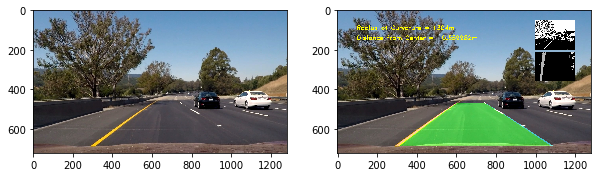

In [6]:
# Testing on a test image
f, axes= plt.subplots(1,2,figsize=(10,20))

# Initializing left and right lines as instance of Line() class
left_line = Line()
right_line = Line()
src = np.float32([[550, 470], [760, 470], [1125, 670], [200, 670]]) # hyper-param

# Executing pipeline()
path_dir = os.getcwd()+"\\test_images\\"
img_input = cv2.imread(path_dir+"test6.jpg")
original_img = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
axes[0].imshow(original_img)
result_img = pipeline(original_img,left_line,right_line,src)
cv2.imwrite('output_images/test_img6.jpg', cv2.cvtColor(result_img,cv2.COLOR_BGR2RGB))
axes[1].imshow(result_img)


### Running Image Pipeline on sample video

In [7]:
# Path to write video result
path_dir = os.getcwd()+"\\output_videos\\"

# Initializing left and right lines as instance of Line() class
left_line = Line()
right_line = Line()
src = np.float32([[550, 470], [760, 470], [1125, 670], [200, 670]]) # hyper-param

# Running pipeline() on project_video.mp4
import moviepy
from moviepy.editor import VideoFileClip
input_projVideo = VideoFileClip('project_video.mp4')
video_projVideo = path_dir+'project_video_output.mp4'
processed_video = input_projVideo.fl_image((lambda image: pipeline(image,left_line,right_line,src)))
%time processed_video.write_videofile(video_projVideo, audio=False)

[MoviePy] >>>> Building video C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\project_video_output.mp4
[MoviePy] Writing video C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:38<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\project_video_output.mp4 

Wall time: 6min 41s


In [8]:
# Initializing left and right lines as instance of Line() class
left_line = Line()
right_line = Line()
src = np.float32([[550, 470], [760, 470], [1125, 670], [200, 670]]) # hyper-param

# Path to write video result
path_dir = os.getcwd()+"\\output_videos\\"

# Running pipeline() on challenge_video.mp4
import moviepy
from moviepy.editor import VideoFileClip
input_challengeVideo = VideoFileClip('challenge_video.mp4')
video_challengeVideo = path_dir+'challenge_video_output.mp4'
#processed_video = input_challengeVideo.fl_image(pipeline)
processed_video = input_challengeVideo.fl_image((lambda image: pipeline(image,left_line,right_line,src)))
%time processed_video.write_videofile(video_challengeVideo, audio=False)

[MoviePy] >>>> Building video C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\challenge_video_output.mp4
[MoviePy] Writing video C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\challenge_video_output.mp4


100%|████████████████████████████████████████| 485/485 [02:31<00:00,  2.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\challenge_video_output.mp4 

Wall time: 2min 34s


In [9]:
# Initializing left and right lines as instance of Line() class
left_line = Line()
right_line = Line()
src = np.float32([[550, 470], [760, 470], [1125, 670], [200, 670]]) # hyper-param

# Path to write video result
path_dir = os.getcwd()+"\\output_videos\\"

# Running pipeline() on harder_challenge_video.mp4
import moviepy
from moviepy.editor import VideoFileClip
input_hardChallenge = VideoFileClip('harder_challenge_video.mp4')
video_hardChallenge = path_dir+'harder_challenge_video_output.mp4'
#processed_video = input_hardChallenge.fl_image(pipeline)
processed_video = input_hardChallenge.fl_image((lambda image: pipeline(image,left_line,right_line,src)))
%time processed_video.write_videofile(video_hardChallenge, audio=False)

[MoviePy] >>>> Building video C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\harder_challenge_video_output.mp4
[MoviePy] Writing video C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\harder_challenge_video_output.mp4


100%|█████████████████████████████████████▉| 1199/1200 [07:42<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\harder_challenge_video_output.mp4 

Wall time: 7min 46s
